# Restrict Area by Elevation Threshold

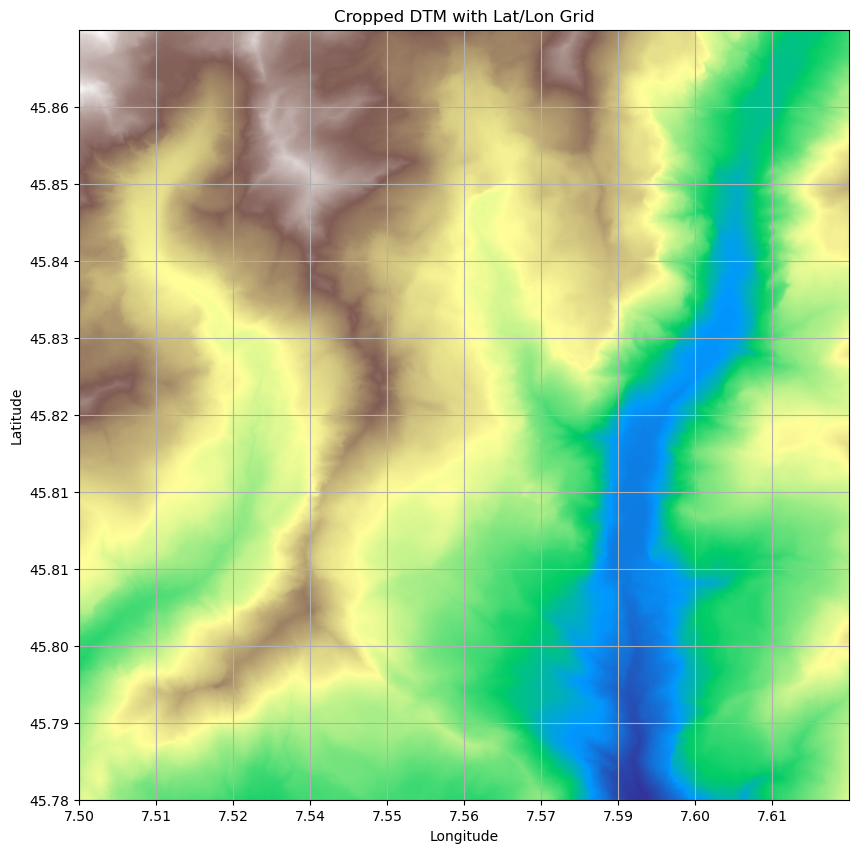

In [48]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from pyproj import Proj, Transformer, CRS
import numpy as np
import pandas as pd

# Open the .tif file
tif_path = '../data_store/data/torgnon/elevation/w50535_s10.tif'
with rasterio.open(tif_path) as src:
    center_lat = 45.8238
    center_lon = 7.5609
    radius = 5000

    # Define CRS
    wgs84 = CRS.from_epsg(4326)
    transformer = Transformer.from_crs(wgs84, src.crs, always_xy=True)

    # Transform center to CRS of the TIFF
    center_x, center_y = transformer.transform(center_lon, center_lat)

    # Define bounding box
    min_x = center_x - radius
    max_x = center_x + radius
    min_y = center_y - radius
    max_y = center_y + radius

    # Crop image
    window = rasterio.windows.from_bounds(min_x, min_y, max_x, max_y, src.transform)
    cropped_image = src.read(1, window=window)
    cropped_transform = src.window_transform(window)

    fig, ax = plt.subplots(figsize=(10, 10))
    show(cropped_image, transform=cropped_transform, cmap='terrain', ax=ax)

    # Grid size and transformation for grid lines
    grid_size = 1000  # Grid size in meters
    x_coords = np.arange(min_x, max_x, grid_size)
    y_coords = np.arange(min_y, max_y, grid_size)

    # Inverse transform for tick labels
    transformer_inv = Transformer.from_crs(src.crs, wgs84, always_xy=True)
    lon_ticks, lat_ticks = [], []
    for x in x_coords:
        lon, _ = transformer_inv.transform(x, center_y)
        lon_ticks.append(lon)
    for y in y_coords:
        _, lat = transformer_inv.transform(center_x, y)
        lat_ticks.append(lat)

    # Set ticks and labels
    ax.set_xticks(x_coords)
    ax.set_yticks(y_coords)
    ax.set_xticklabels([f"{lon:.2f}" for lon in lon_ticks])
    ax.set_yticklabels([f"{lat:.2f}" for lat in lat_ticks])

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.title('Cropped DTM with Lat/Lon Grid')
    plt.savefig('./images/elevation/torgnon_dtm.jpg')
    plt.show()


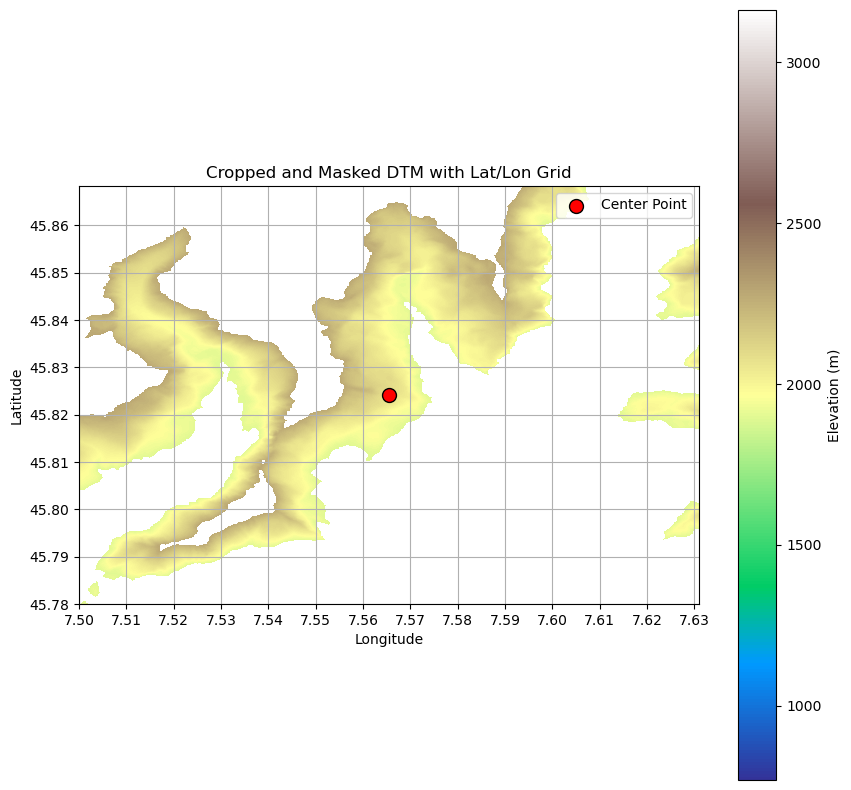

The area of the region within 200m of 2091m elevation is 32083200.00 square meters.


In [49]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.windows import from_bounds
from pyproj import Proj, Transformer, CRS
import numpy as np

# Open the raster data
tif_path = '../data_store/data/torgnon/elevation/w50535_s10.tif'
with rasterio.open(tif_path) as src:
    # Define the center point and box dimensions
    center_lat = 45.8238
    center_lon = 7.5609
    radius = 5000  # 10km / 2 = 5km each side

    # Define CRS and transformer for coordinate conversion
    wgs84 = CRS.from_epsg(4326)
    tif_crs = src.crs
    transformer = Transformer.from_crs(wgs84, tif_crs, always_xy=True)
    transformer_inv = Transformer.from_crs(tif_crs, wgs84, always_xy=True)

    # Transform the center point to the coordinate system of the .tif file
    center_x, center_y = transformer.transform(center_lon, center_lat)

    # Define the bounding box in the coordinate system of the .tif file
    min_x = center_x - radius
    max_x = center_x + radius
    min_y = center_y - radius
    max_y = center_y + radius

    # Crop the .tif file to the bounding box
    window = from_bounds(min_x, min_y, max_x, max_y, src.transform)
    cropped_image = src.read(1, window=window)
    cropped_transform = src.window_transform(window)

    # Mask the regions where the elevation is within 200 meters of 2091 meters
    target_elevation = 2091
    elevation_tolerance = 200
    mask = (cropped_image >= (target_elevation - elevation_tolerance)) & (cropped_image <= (target_elevation + elevation_tolerance))
    masked_dtm = np.where(mask, cropped_image, np.nan)  # Set non-masked areas to NaN

    # Compute the area of the masked region
    pixel_area = np.product(src.res)  # Calculate the area of one pixel in square meters
    masked_area = np.sum(mask) * pixel_area

    # Convert image coordinates to geographic coordinates for extent
    top_left_lon, top_left_lat = transformer_inv.transform(min_x, max_y)
    bottom_right_lon, bottom_right_lat = transformer_inv.transform(max_x, min_y)

    # Display the masked DTM region with the correct latitude/longitude grid
    fig, ax = plt.subplots(figsize=(10, 10))
    extent = [top_left_lon, bottom_right_lon, bottom_right_lat, top_left_lat]
    cax = ax.imshow(masked_dtm, cmap='terrain', vmin=np.nanmin(cropped_image), vmax=np.nanmax(cropped_image),
                    extent=extent, origin='upper')

    # Grid size and transformation for grid lines
    grid_size = 0.01  # Grid size in degrees (roughly corresponds to the grid size in meters)

    # Set ticks and labels using geographic coordinates
    ax.set_xticks(np.arange(extent[0], extent[1], grid_size))
    ax.set_yticks(np.arange(extent[2], extent[3], grid_size))
    ax.set_xticklabels([f"{lon:.2f}" for lon in ax.get_xticks()])
    ax.set_yticklabels([f"{lat:.2f}" for lat in ax.get_yticks()])

    # Add center point (latitude/longitude)
    ax.scatter(center_lon, center_lat, color='red', s=100, edgecolor='black', label='Center Point')
    ax.legend()

    plt.colorbar(cax, ax=ax, label='Elevation (m)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.title('Cropped and Masked DTM with Lat/Lon Grid')
    plt.savefig('./images/elevation/dtm_100m_tolerance_and_camera_location.jpg')
    plt.show()

    # Print the area of the masked region
    print(f'The area of the region within 200m of {target_elevation}m elevation is {masked_area:.2f} square meters.')


# Snow Cover by NDSI

In [8]:
from scripts.imports import *


def extract_nums(text, point = 'ul'):
    # Define the regular expression pattern

    if point == 'ul':
        pattern = r'UpperLeftPointMtrs=\((.*?)\)'
    else:
        pattern = r'LowerRightMtrs=\((.*?)\)'
    
    # Search for the pattern in the text
    match = re.search(pattern, text)
    
    # Check if a match is found
    if match:
        # Extract the matched group (the characters between the parentheses)
        result = match.group(1)
        return parse_coordinates(result)
    else:
        return None, None

def parse_coordinates(coordinate_str):
    try:
        # Split the string by comma
        x_str, y_str = coordinate_str.split(',')
        
        # Convert the split strings to floats
        x = float(x_str)
        y = float(y_str)
        
        return x, y
    except ValueError:
        # Handle the case where conversion to float fails
        return None, None

# start = 'MYD'
# place='torgnon'
# target_lat = 45.8238
# target_lon = 7.5609

# hdf_dir = f'../data_store/data/{start}10A1F_{place}/'

# Function to get day of year (DOY) from a date in 'dd/mm/yyyy' format
def get_day_of_year(date_str):
    date_obj = pd.to_datetime(date_str, format='%d/%m/%Y')
    return date_obj.strftime('%j')

# Function to find HDF file that matches the pattern MOD10A1F.AYYYYDDD*.hdf
def find_matching_hdf(year, day_of_year, start, hdf_dirf):
    # Construct the prefix and suffix to match
    prefix = f'{start}10A1F.A{year}{day_of_year}'
    suffix = '.hdf'
    
    # List all files in the directory
    files = os.listdir(hdf_dir)
    
    # Find the matching HDF file
    for file in files:
        if file.startswith(prefix) and file.endswith(suffix):
            return file
    
    return None

# Function to convert HDF file to latitude and longitude arrays
def hdf_to_latlon(hdf_path):
    # Open HDF file and extract necessary data
    hdf = SD(hdf_path, SDC.READ)
    dataset = hdf.select('CGF_NDSI_Snow_Cover')
    data = dataset[:]
    
    # Get grid parameters from the metadata
    ulx, uly = extract_nums(hdf.attributes()['StructMetadata.0'], point='ul')
    lrx, lry = extract_nums(hdf.attributes()['StructMetadata.0'], point='lr')
    nx, ny = data.shape
    
    # Define the spatial resolution
    xres = (lrx - ulx) / float(nx)
    yres = (uly - lry) / float(ny)
    
    # Define the grid
    x = np.linspace(ulx + xres / 2, lrx - xres / 2, nx)
    y = np.linspace(uly - yres / 2, lry + yres / 2, ny)
    xv, yv = np.meshgrid(x, y)
    
    # Convert the projection to lat/lon using pyproj
    proj = pyproj.Proj(proj='sinu', R=6371007.181, no_defs=True)
    lon, lat = proj(xv, yv, inverse=True)
    
    # Close HDF file
    hdf.end()
    
    return lat, lon, data

/tmp/ipykernel_1753574/3314045071.py:64: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = pyproj.transform(sin_proj, wgs84_proj, xv, yv)


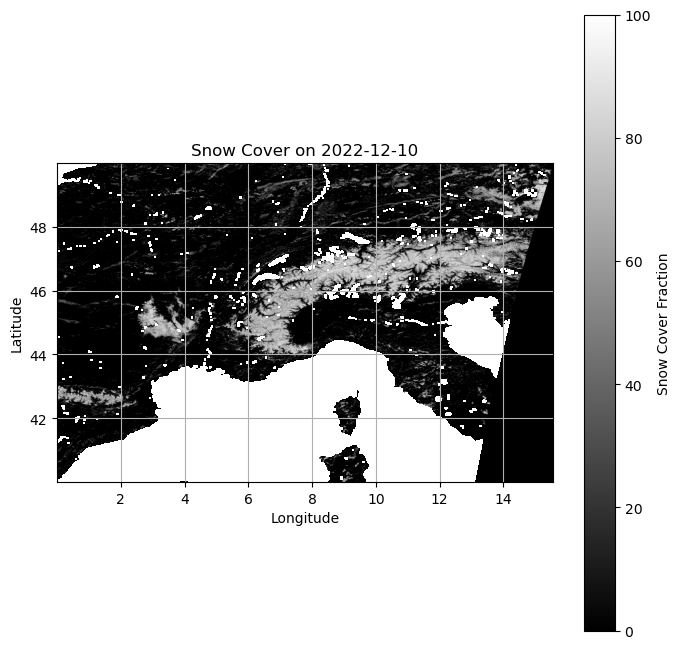

In [2]:
from scripts.imports import *
import numpy as np
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC
import pyproj
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.transform import from_bounds

def extract_nums(text, point='ul'):
    if point == 'ul':
        pattern = r'UpperLeftPointMtrs=\((.*?)\)'
    else:
        pattern = r'LowerRightMtrs=\((.*?)\)'
    
    match = re.search(pattern, text)
    if match:
        result = match.group(1)
        return parse_coordinates(result)
    else:
        return None, None

def parse_coordinates(coordinate_str):
    try:
        x_str, y_str = coordinate_str.split(',')
        x = float(x_str)
        y = float(y_str)
        return x, y
    except ValueError:
        return None, None

def get_day_of_year(date_str):
    date_obj = pd.to_datetime(date_str)
    return date_obj.strftime('%j')

def find_matching_hdf(year, day_of_year, start, hdf_dir):
    prefix = f'{start}10A1F.A{year}{day_of_year}'
    suffix = '.hdf'
    files = os.listdir(hdf_dir)
    for file in files:
        if file.startswith(prefix) and file.endswith(suffix):
            return file
    return None

def hdf_to_latlon(hdf_path):
    hdf = SD(hdf_path, SDC.READ)
    dataset = hdf.select('CGF_NDSI_Snow_Cover')
    data = dataset[:]
    
    ulx, uly = extract_nums(hdf.attributes()['StructMetadata.0'], point='ul')
    lrx, lry = extract_nums(hdf.attributes()['StructMetadata.0'], point='lr')
    nx, ny = data.shape
    
    xres = (lrx - ulx) / float(nx)
    yres = (uly - lry) / float(ny)
    
    x = np.linspace(ulx + xres / 2, lrx - xres / 2, nx)
    y = np.linspace(uly - yres / 2, lry + yres / 2, ny)
    xv, yv = np.meshgrid(x, y)
    
    sin_proj = pyproj.Proj(proj='sinu', R=6371007.181, no_defs=True)
    wgs84_proj = pyproj.Proj(proj='latlong', datum='WGS84')
    
    lon, lat = pyproj.transform(sin_proj, wgs84_proj, xv, yv)
    
    hdf.end()
    
    return lat, lon, data, ulx, uly, lrx, lry

# Set the date
date_str = '2022-12-10'
day_of_year = get_day_of_year(date_str)
year = date_str[:4]

# Specify the directory and prefix for MODIS data
start = 'MOD'
place = 'torgnon'
hdf_dir = f'../data_store/data/{start}10A1F_{place}/'

# Find the matching HDF file
hdf_filename = find_matching_hdf(year, day_of_year, start, hdf_dir)

if hdf_filename:
    hdf_path = os.path.join(hdf_dir, hdf_filename)
    latitude, longitude, snow_cover_data, ulx, uly, lrx, lry = hdf_to_latlon(hdf_path)
    
    # Now we reproject the data
    src_transform = from_bounds(ulx, lry, lrx, uly, snow_cover_data.shape[1], snow_cover_data.shape[0])
    src_crs = rasterio.crs.CRS.from_proj4('+proj=sinu +R=6371007.181 +nadgrids=@null +wktext')

    dst_transform, width, height = calculate_default_transform(
        src_crs, 'EPSG:4326', snow_cover_data.shape[1], snow_cover_data.shape[0], 
        left=ulx, bottom=lry, right=lrx, top=uly
    )

    reprojected_data = np.empty((height, width), np.float32)

    reproject(
        source=snow_cover_data,
        destination=reprojected_data,
        src_transform=src_transform,
        src_crs=src_crs,  # Sinusoidal projection
        dst_transform=dst_transform,
        dst_crs='EPSG:4326',
        resampling=Resampling.nearest
    )
    
    reprojected_data[reprojected_data > 100] = np.nan

    # Plotting the reprojected data
    plt.figure(figsize=(8, 8))
    img = plt.imshow(reprojected_data, extent=(longitude.min(), longitude.max(), latitude.min(), latitude.max()), origin='upper', cmap='gray', vmin=0, vmax=100)
    plt.colorbar(img, label='Snow Cover Fraction')
    plt.title(f'Snow Cover on {date_str}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()
else:
    print(f"No HDF file found for {date_str} in directory.")


/tmp/ipykernel_748312/164397049.py:72: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  longitude, latitude = pyproj.transform(sin_proj, wgs84_proj, xv, yv)


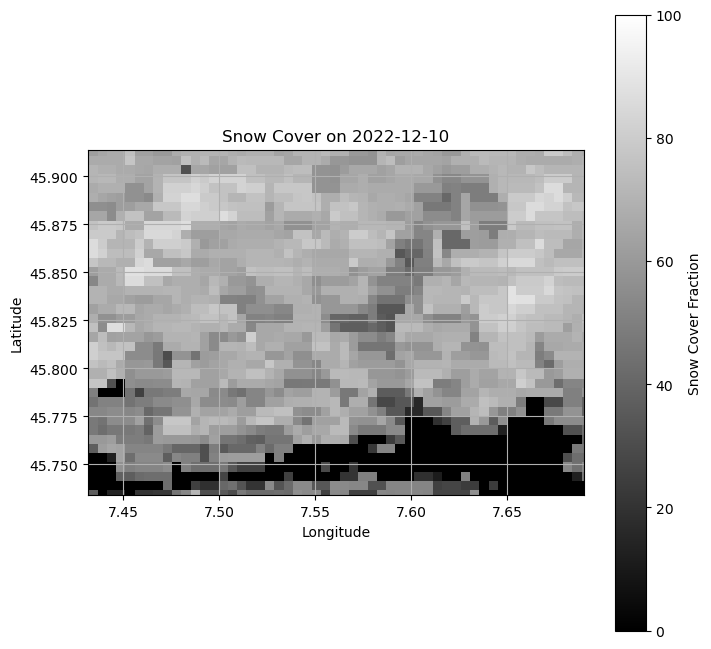

In [46]:
from scripts.imports import *
import numpy as np
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC
import pyproj
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.transform import from_bounds

def find_matching_hdf(year, day_of_year, start, hdf_dirf):
    # Construct the prefix and suffix to match
    prefix = f'{start}10A1F.A{year}{day_of_year}'
    suffix = '.hdf'
    
    # List all files in the directory
    files = os.listdir(hdf_dir)
    
    # Find the matching HDF file
    for file in files:
        if file.startswith(prefix) and file.endswith(suffix):
            return file
    
    return None

# Additional helper functions as per your previous script context
def extract_nums(text, point='ul'):
    import re
    pattern = r'UpperLeftPointMtrs=\((.*?)\)' if point == 'ul' else r'LowerRightMtrs=\((.*?)\)'
    match = re.search(pattern, text)
    return tuple(map(float, match.group(1).split(','))) if match else (None, None)

# Set the specific location and extent to match the first plot
center_lat = 45.8238
center_lon = 7.5609
radius = 10000  # Half the size of the box for 10 km by 10 km

# Convert radius in meters to degrees approximately (rough approximation)
radius_deg_lat = radius / 111000
radius_deg_lon = radius / (111000 * np.cos(np.radians(center_lat)))

# Latitude and longitude bounds matching the first plot
lat_min = center_lat - radius_deg_lat
lat_max = center_lat + radius_deg_lat
lon_min = center_lon - radius_deg_lon
lon_max = center_lon + radius_deg_lon

# Function to get day of year (DOY) from a date in 'yyyy-mm-dd' format
def get_day_of_year(date_str):
    date_obj = pd.to_datetime(date_str)
    return date_obj.strftime('%j')

# Function to convert HDF file to latitude and longitude arrays
def hdf_to_latlon(hdf_path):
    hdf = SD(hdf_path, SDC.READ)
    dataset = hdf.select('CGF_NDSI_Snow_Cover')
    data = dataset[:]
    
    ulx, uly = extract_nums(hdf.attributes()['StructMetadata.0'], point='ul')
    lrx, lry = extract_nums(hdf.attributes()['StructMetadata.0'], point='lr')
    nx, ny = data.shape
    
    xres = (lrx - ulx) / float(nx)
    yres = (uly - lry) / float(ny)
    
    x = np.linspace(ulx + xres / 2, lrx - xres / 2, nx)
    y = np.linspace(uly - yres / 2, lry + yres / 2, ny)
    xv, yv = np.meshgrid(x, y)
    
    sin_proj = pyproj.Proj(proj='sinu', R=6371007.181, no_defs=True)
    wgs84_proj = pyproj.Proj(proj='latlong', datum='WGS84')
    
    longitude, latitude = pyproj.transform(sin_proj, wgs84_proj, xv, yv)
    
    hdf.end()
    
    return latitude, longitude, data, ulx, uly, lrx, lry

# Load data and restrict plotting
date_str = '2022-12-10'
day_of_year = get_day_of_year(date_str)
year = date_str[:4]
start = 'MOD'
place = 'torgnon'
hdf_dir = f'../data_store/data/{start}10A1F_{place}/'
hdf_filename = find_matching_hdf(year, day_of_year, start, hdf_dir)

if hdf_filename:
    hdf_path = os.path.join(hdf_dir, hdf_filename)
    latitude, longitude, snow_cover_data, ulx, uly, lrx, lry = hdf_to_latlon(hdf_path)
    
    # Reprojection setup
    src_transform = from_bounds(ulx, lry, lrx, uly, snow_cover_data.shape[1], snow_cover_data.shape[0])
    src_crs = rasterio.crs.CRS.from_proj4('+proj=sinu +R=6371007.181 +nadgrids=@null +wktext')

    dst_transform, width, height = calculate_default_transform(
        src_crs, 'EPSG:4326', snow_cover_data.shape[1], snow_cover_data.shape[0], 
        left=ulx, bottom=lry, right=lrx, top=uly
    )

    reprojected_data = np.empty((height, width), np.float32)

    reproject(
        source=snow_cover_data,
        destination=reprojected_data,
        src_transform=src_transform,
        src_crs=src_crs,  # Sinusoidal projection
        dst_transform=dst_transform,
        dst_crs='EPSG:4326',
        resampling=Resampling.nearest
    )
    
    reprojected_data[reprojected_data > 100] = np.nan
    
    # Plotting the reprojected data with the region of interest
    plt.figure(figsize=(8, 8))
    plt.imshow(reprojected_data, extent=(longitude.min(), longitude.max(), latitude.min(), latitude.max()), origin='upper', cmap='gray', vmin=0, vmax=100)
    plt.xlim(lon_min, lon_max)  # Restrict to region of interest
    plt.ylim(lat_min, lat_max)  # Restrict to region of interest
    plt.colorbar(label='Snow Cover Fraction')
    plt.title(f'Snow Cover on {date_str}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()
else:
    print(f"No HDF file found for {date_str} in directory.")


# Adapt from single point elevation to elevation distributions to mask pixels

### Elevation Distribution and 80%

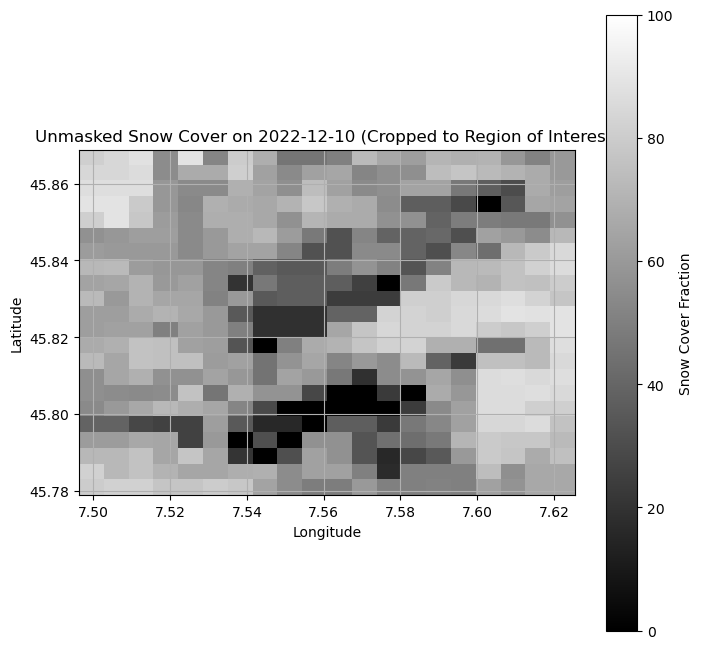

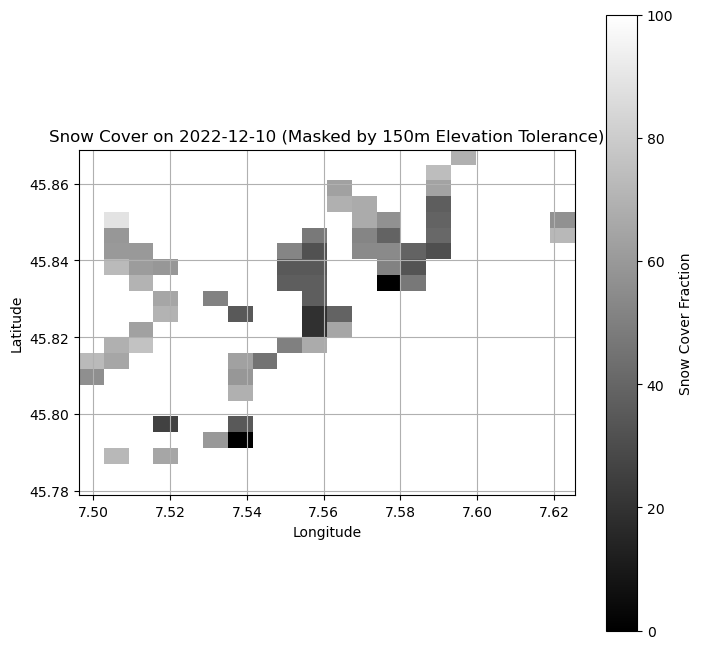

In [5]:
from scripts.imports import *
from rasterio.enums import Resampling
from rasterio.warp import reproject, calculate_default_transform
from rasterio.plot import show
from rasterio.windows import from_bounds
import numpy as np

def find_matching_hdf(year, day_of_year, start, hdf_dirf):
    # Construct the prefix and suffix to match
    prefix = f'{start}10A1F.A{year}{day_of_year}'
    suffix = '.hdf'
    
    # List all files in the directory
    files = os.listdir(hdf_dir)
    
    # Find the matching HDF file
    for file in files:
        if file.startswith(prefix) and file.endswith(suffix):
            return file
    
    return None

# Additional helper functions as per your previous script context
def extract_nums(text, point='ul'):
    import re
    pattern = r'UpperLeftPointMtrs=\((.*?)\)' if point == 'ul' else r'LowerRightMtrs=\((.*?)\)'
    match = re.search(pattern, text)
    return tuple(map(float, match.group(1).split(','))) if match else (None, None)

# Set the specific location and extent to match the first plot
center_lat = 45.8238
center_lon = 7.5609
radius = 5000  # Half the size of the box for 10 km by 10 km

# Convert radius in meters to degrees approximately (rough approximation)
radius_deg_lat = radius / 111000
radius_deg_lon = radius / (111000 * np.cos(np.radians(center_lat)))

# Latitude and longitude bounds matching the first plot
lat_min = center_lat - radius_deg_lat
lat_max = center_lat + radius_deg_lat
lon_min = center_lon - radius_deg_lon
lon_max = center_lon + radius_deg_lon

# Function to get day of year (DOY) from a date in 'yyyy-mm-dd' format
def get_day_of_year(date_str):
    date_obj = pd.to_datetime(date_str)
    return date_obj.strftime('%j')

# Function to convert HDF file to latitude and longitude arrays
def hdf_to_latlon(hdf_path):
    hdf = SD(hdf_path, SDC.READ)
    dataset = hdf.select('CGF_NDSI_Snow_Cover')
    data = dataset[:]
    ulx, uly = extract_nums(hdf.attributes()['StructMetadata.0'], point='ul')
    lrx, lry = extract_nums(hdf.attributes()['StructMetadata.0'], point='lr')
    nx, ny = data.shape
    xres = (lrx - ulx) / float(nx)
    yres = (uly - lry) / float(ny)
    x = np.linspace(ulx + xres / 2, lrx - xres / 2, nx)
    y = np.linspace(uly - yres / 2, lry + yres / 2, ny)
    xv, yv = np.meshgrid(x, y)
    proj = pyproj.Proj(proj='sinu', R=6371007.181, no_defs=True)
    lon, lat = proj(xv, yv, inverse=True)
    hdf.end()
    return lat, lon, data

# Load data for December 10th, 2022
date_str = '2022-12-10'
day_of_year = get_day_of_year(date_str)
year = date_str[:4]
start = 'MOD'
place = 'torgnon'
hdf_dir = f'../data_store/data/{start}10A1F_{place}/'
hdf_filename = find_matching_hdf(year, day_of_year, start, hdf_dir)

location_elevation = 2091
tolerance = 150

# Load the elevation data
tif_path = '../data_store/data/torgnon/elevation/w50535_s10.tif'
with rasterio.open(tif_path) as src:
    # Define the center point and box dimensions
    wgs84 = CRS.from_epsg(4326)
    tif_crs = src.crs
    transformer = Transformer.from_crs(wgs84, tif_crs, always_xy=True)
    center_x, center_y = transformer.transform(center_lon, center_lat)

    min_x = center_x - radius
    max_x = center_x + radius
    min_y = center_y - radius
    max_y = center_y + radius

    window = from_bounds(min_x, min_y, max_x, max_y, src.transform)
    elevation_data = src.read(1, window=window)

if hdf_filename:
    hdf_path = os.path.join(hdf_dir, hdf_filename)
    latitude, longitude, snow_cover_data = hdf_to_latlon(hdf_path)

    # Find indices that match the region of interest
    lat_indices = np.where((latitude[:,0] >= lat_min) & (latitude[:,0] <= lat_max))[0]
    lon_indices = np.where((longitude[0,:] >= lon_min) & (longitude[0,:] <= lon_max))[0]

    # Crop the snow cover data based on the indices
    cropped_snow_cover_data = snow_cover_data[lat_indices.min():lat_indices.max()+1, lon_indices.min():lon_indices.max()+1]
    cropped_latitude = latitude[lat_indices.min():lat_indices.max()+1, lon_indices.min():lon_indices.max()+1]
    cropped_longitude = longitude[lat_indices.min():lat_indices.max()+1, lon_indices.min():lon_indices.max()+1]

    # Calculate the elevation distribution within each MOD10A1F pixel using the aligned elevation data
    pixel_size_y = elevation_data.shape[0] // cropped_snow_cover_data.shape[0]
    pixel_size_x = elevation_data.shape[1] // cropped_snow_cover_data.shape[1]

    mask = np.zeros_like(cropped_snow_cover_data, dtype=bool)

    for i in range(cropped_snow_cover_data.shape[0]):
        for j in range(cropped_snow_cover_data.shape[1]):
            # Extract the corresponding elevation data for the pixel
            elevation_block = elevation_data[i*pixel_size_y:(i+1)*pixel_size_y, j*pixel_size_x:(j+1)*pixel_size_x]
            
            # Flatten the block and remove NaNs
            elevation_values = elevation_block.flatten()
            elevation_values = elevation_values[~np.isnan(elevation_values)]
            
            # Compute the percentage of values within the tolerance
            within_tolerance = (elevation_values >= (location_elevation - tolerance)) & (elevation_values <= (location_elevation + tolerance))
            percentage_within_tolerance = np.sum(within_tolerance) / len(elevation_values)
            
            # If 75% or more of the elevation values are within the tolerance, include this pixel
            mask[i, j] = percentage_within_tolerance >= 0.80

    # Apply the mask to the snow cover data
    masked_snow_cover_data = np.where(mask, cropped_snow_cover_data, np.nan)

    # Plot the unmasked snow cover data (cropped)
    plt.figure(figsize=(8, 8))
    plt.imshow(cropped_snow_cover_data, extent=(lon_min, lon_max, lat_min, lat_max), origin='upper', cmap='gray', vmin=0, vmax=100)
    plt.colorbar(label='Snow Cover Fraction')
    plt.title(f'Unmasked Snow Cover on {date_str} (Cropped to Region of Interest)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

    # Plot the masked snow cover data (cropped)
    plt.figure(figsize=(8, 8))
    plt.imshow(masked_snow_cover_data, extent=(lon_min, lon_max, lat_min, lat_max), origin='upper', cmap='gray', vmin=0, vmax=100)
    plt.colorbar(label='Snow Cover Fraction')
    plt.title(f'Snow Cover on {date_str} (Masked by {tolerance}m Elevation Tolerance)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()
else:
    print(f"No HDF file found for {date_str} in directory.")


/tmp/ipykernel_748312/2544196890.py:64: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  longitude, latitude = pyproj.transform(sin_proj, wgs84_proj, xv, yv)
/tmp/ipykernel_748312/2544196890.py:155: RuntimeWarning: invalid value encountered in scalar divide
  percentage_within_tolerance = np.sum(within_tolerance) / len(elevation_values)


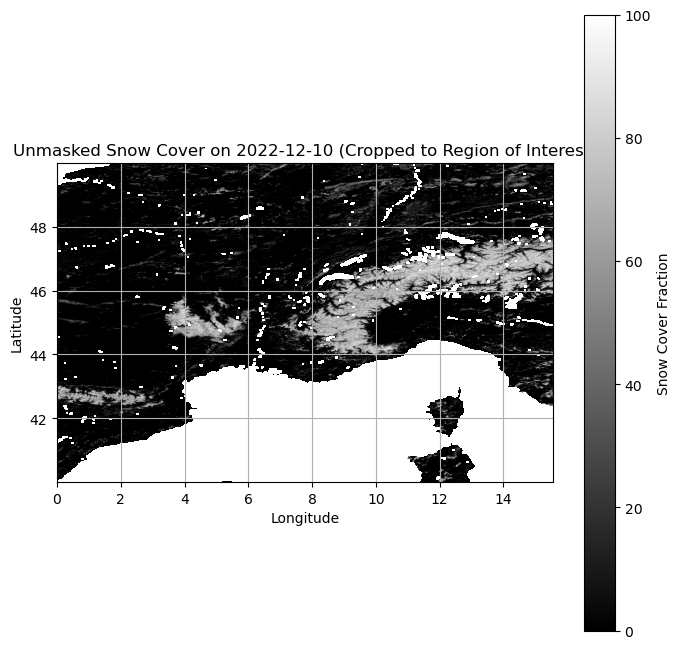

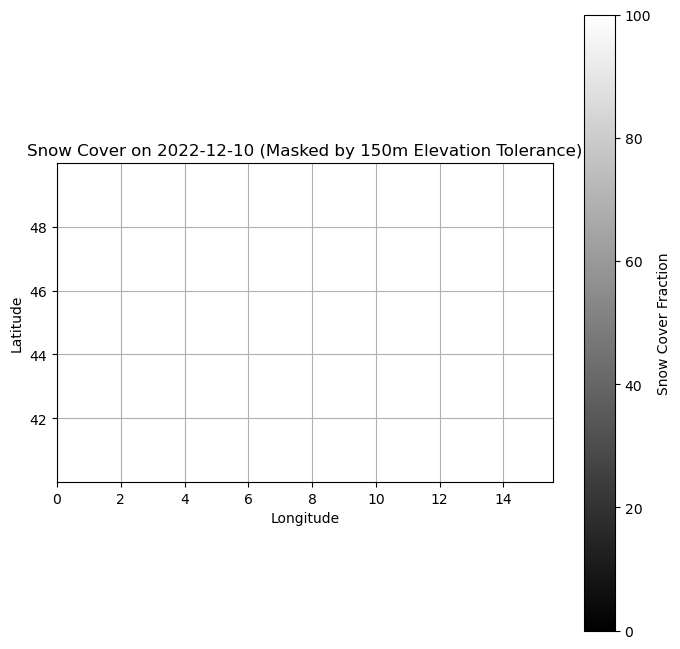

In [44]:
from scripts.imports import *
import numpy as np
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC
import pyproj
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.transform import from_bounds as transform_from_bounds
from rasterio.windows import from_bounds as window_from_bounds

def find_matching_hdf(year, day_of_year, start, hdf_dir):
    prefix = f'{start}10A1F.A{year}{day_of_year}'
    suffix = '.hdf'
    files = os.listdir(hdf_dir)
    for file in files:
        if file.startswith(prefix) and file.endswith(suffix):
            return file
    return None

def extract_nums(text, point='ul'):
    import re
    pattern = r'UpperLeftPointMtrs=\((.*?)\)' if point == 'ul' else r'LowerRightMtrs=\((.*?)\)'
    match = re.search(pattern, text)
    return tuple(map(float, match.group(1).split(','))) if match else (None, None)

# Set the specific location and extent to match the first plot
center_lat = 45.8238
center_lon = 7.5609
radius = 5000  # Half the size of the box for 10 km by 10 km

# Convert radius in meters to degrees approximately (rough approximation)
radius_deg_lat = radius / 111000
radius_deg_lon = radius / (111000 * np.cos(np.radians(center_lat)))

# Latitude and longitude bounds matching the first plot
lat_min = center_lat - radius_deg_lat
lat_max = center_lat + radius_deg_lat
lon_min = center_lon - radius_deg_lon
lon_max = center_lon + radius_deg_lon

def get_day_of_year(date_str):
    date_obj = pd.to_datetime(date_str)
    return date_obj.strftime('%j')

def hdf_to_latlon(hdf_path):
    hdf = SD(hdf_path, SDC.READ)
    dataset = hdf.select('CGF_NDSI_Snow_Cover')
    data = dataset[:]
    
    ulx, uly = extract_nums(hdf.attributes()['StructMetadata.0'], point='ul')
    lrx, lry = extract_nums(hdf.attributes()['StructMetadata.0'], point='lr')
    nx, ny = data.shape
    
    xres = (lrx - ulx) / float(nx)
    yres = (uly - lry) / float(ny)
    
    x = np.linspace(ulx + xres / 2, lrx - xres / 2, nx)
    y = np.linspace(uly - yres / 2, lry + yres / 2, ny)
    xv, yv = np.meshgrid(x, y)
    
    sin_proj = pyproj.Proj(proj='sinu', R=6371007.181, no_defs=True)
    wgs84_proj = pyproj.Proj(proj='latlong', datum='WGS84')
    
    longitude, latitude = pyproj.transform(sin_proj, wgs84_proj, xv, yv)
    
    hdf.end()
    
    return latitude, longitude, data, ulx, uly, lrx, lry

# Load data for December 10th, 2022
date_str = '2022-12-10'
day_of_year = get_day_of_year(date_str)
year = date_str[:4]
start = 'MOD'
place = 'torgnon'
hdf_dir = f'../data_store/data/{start}10A1F_{place}/'
hdf_filename = find_matching_hdf(year, day_of_year, start, hdf_dir)

location_elevation = 2091
tolerance = 150

# Load the elevation data
tif_path = '../data_store/data/torgnon/elevation/w50535_s10.tif'
with rasterio.open(tif_path) as src:
    wgs84 = CRS.from_epsg(4326)
    tif_crs = src.crs
    transformer = Transformer.from_crs(wgs84, tif_crs, always_xy=True)
    center_x, center_y = transformer.transform(center_lon, center_lat)

    min_x = center_x - radius
    max_x = center_x + radius
    min_y = center_y - radius
    max_y = center_y + radius
    
    window = window_from_bounds(min_x, min_y, max_x, max_y, transform=src.transform)
    elevation_data = src.read(1, window=window)

if hdf_filename:
    hdf_path = os.path.join(hdf_dir, hdf_filename)
    latitude, longitude, snow_cover_data, ulx, uly, lrx, lry = hdf_to_latlon(hdf_path)
    
    # Reproject the snow cover data to WGS84
    src_transform = transform_from_bounds(ulx, lry, lrx, uly, snow_cover_data.shape[1], snow_cover_data.shape[0])
    src_crs = rasterio.crs.CRS.from_proj4('+proj=sinu +R=6371007.181 +nadgrids=@null +wktext')

    dst_transform, width, height = calculate_default_transform(
        src_crs, 'EPSG:4326', snow_cover_data.shape[1], snow_cover_data.shape[0], 
        left=ulx, bottom=lry, right=lrx, top=uly
    )

    reprojected_data = np.empty((height, width), np.float32)

    reproject(
        source=snow_cover_data,
        destination=reprojected_data,
        src_transform=src_transform,
        src_crs=src_crs,  # Sinusoidal projection
        dst_transform=dst_transform,
        dst_crs='EPSG:4326',
        resampling=Resampling.nearest
    )
    
    reprojected_data[reprojected_data > 100] = np.nan
    
    # Recalculate the extent after reprojection
    lon_min, lat_min = dst_transform * (0, height)
    lon_max, lat_max = dst_transform * (width, 0)
    
    # Find indices that match the region of interest
    lat_indices = np.where((latitude[:, 0] >= lat_min) & (latitude[:, 0] <= lat_max))[0]
    lon_indices = np.where((longitude[0, :] >= lon_min) & (longitude[0, :] <= lon_max))[0]

    # Crop the snow cover data based on the indices
    cropped_snow_cover_data = reprojected_data[lat_indices.min():lat_indices.max()+1, lon_indices.min():lon_indices.max()+1]
    cropped_latitude = latitude[lat_indices.min():lat_indices.max()+1, lon_indices.min():lon_indices.max()+1]
    cropped_longitude = longitude[lat_indices.min():lat_indices.max()+1, lon_indices.min():lon_indices.max()+1]

    # Calculate the elevation distribution within each MOD10A1F pixel using the aligned elevation data
    pixel_size_y = elevation_data.shape[0] // cropped_snow_cover_data.shape[0]
    pixel_size_x = elevation_data.shape[1] // cropped_snow_cover_data.shape[1]

    mask = np.zeros_like(cropped_snow_cover_data, dtype=bool)

    for i in range(cropped_snow_cover_data.shape[0]):
        for j in range(cropped_snow_cover_data.shape[1]):
            # Extract the corresponding elevation data for the pixel
            elevation_block = elevation_data[i*pixel_size_y:(i+1)*pixel_size_y, j*pixel_size_x:(j+1)*pixel_size_x]
            
            # Flatten the block and remove NaNs
            elevation_values = elevation_block.flatten()
            elevation_values = elevation_values[~np.isnan(elevation_values)]
            
            # Compute the percentage of values within the tolerance
            within_tolerance = (elevation_values >= (location_elevation - tolerance)) & (elevation_values <= (location_elevation + tolerance))
            percentage_within_tolerance = np.sum(within_tolerance) / len(elevation_values)
            
            # If 75% or more of the elevation values are within the tolerance, include this pixel
            mask[i, j] = percentage_within_tolerance >= 0.80

    # Apply the mask to the snow cover data
    masked_snow_cover_data = np.where(mask, cropped_snow_cover_data, np.nan)

    # Plot the unmasked snow cover data (cropped)
    plt.figure(figsize=(8, 8))
    plt.imshow(cropped_snow_cover_data, extent=(lon_min, lon_max, lat_min, lat_max), origin='upper', cmap='gray', vmin=0, vmax=100)
    plt.colorbar(label='Snow Cover Fraction')
    plt.title(f'Unmasked Snow Cover on {date_str} (Cropped to Region of Interest)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()

    # Plot the masked snow cover data (cropped)
    plt.figure(figsize=(8, 8))
    plt.imshow(masked_snow_cover_data, extent=(lon_min, lon_max, lat_min, lat_max), origin='upper', cmap='gray', vmin=0, vmax=100)
    plt.colorbar(label='Snow Cover Fraction')
    plt.title(f'Snow Cover on {date_str} (Masked by {tolerance}m Elevation Tolerance)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()
else:
    print(f"No HDF file found for {date_str} in directory.")


### Dissimilarity with 80% pixel supported altitude tolerances

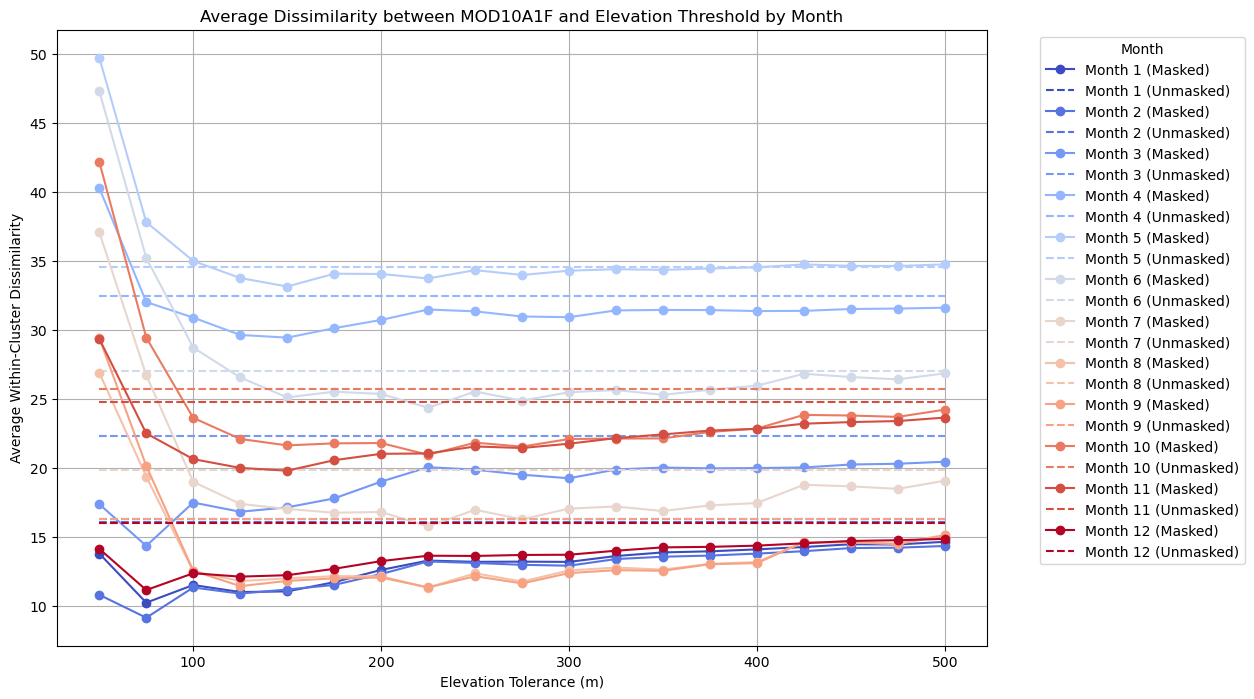

In [6]:
from scripts.imports import *
from rasterio.enums import Resampling
from rasterio.warp import reproject, calculate_default_transform
from rasterio.plot import show
from rasterio.windows import from_bounds
from scipy.spatial.distance import pdist
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
import pandas as pd
import os

# Additional helper functions as per your previous script context
def extract_nums(text, point='ul'):
    import re
    pattern = r'UpperLeftPointMtrs=\((.*?)\)' if point == 'ul' else r'LowerRightMtrs=\((.*?)\)'
    match = re.search(pattern, text)
    return tuple(map(float, match.group(1).split(','))) if match else (None, None)

# Set the specific location and extent to match the first plot
center_lat = 45.8238
center_lon = 7.5609
radius = 5000  # Half the size of the box for 10 km by 10 km

# Convert radius in meters to degrees approximately (rough approximation)
radius_deg_lat = radius / 111000
radius_deg_lon = radius / (111000 * np.cos(np.radians(center_lat)))

# Latitude and longitude bounds matching the first plot
lat_min = center_lat - radius_deg_lat
lat_max = center_lat + radius_deg_lat
lon_min = center_lon - radius_deg_lon
lon_max = center_lon + radius_deg_lon

# Function to get day of year (DOY) from a date in 'yyyy-mm-dd' format
def get_day_of_year(date_str):
    date_obj = pd.to_datetime(date_str)
    return date_obj.strftime('%j')

def find_matching_hdf(year, day_of_year, start, hdf_dirf):
    # Construct the prefix and suffix to match
    prefix = f'{start}10A1F.A{year}{day_of_year}'
    suffix = '.hdf'
    
    # List all files in the directory
    files = os.listdir(hdf_dir)
    
    # Find the matching HDF file
    for file in files:
        if file.startswith(prefix) and file.endswith(suffix):
            return file
    
    return None

# Function to convert HDF file to latitude and longitude arrays
def hdf_to_latlon(hdf_path):
    hdf = SD(hdf_path, SDC.READ)
    dataset = hdf.select('CGF_NDSI_Snow_Cover')
    data = dataset[:]
    ulx, uly = extract_nums(hdf.attributes()['StructMetadata.0'], point='ul')
    lrx, lry = extract_nums(hdf.attributes()['StructMetadata.0'], point='lr')
    nx, ny = data.shape
    xres = (lrx - ulx) / float(nx)
    yres = (uly - lry) / float(ny)
    x = np.linspace(ulx + xres / 2, lrx - xres / 2, nx)
    y = np.linspace(uly - yres / 2, lry + yres / 2, ny)
    xv, yv = np.meshgrid(x, y)
    proj = pyproj.Proj(proj='sinu', R=6371007.181, no_defs=True)
    lon, lat = proj(xv, yv, inverse=True)
    hdf.end()
    return lat, lon, data

# Dates to consider (you may adjust the date range)
start_date = '2018-11-01'
end_date = '2023-11-30'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Load the elevation data
tif_path = '../data_store/data/torgnon/elevation/w50535_s10.tif'
with rasterio.open(tif_path) as src:
    # Define the center point and box dimensions
    wgs84 = CRS.from_epsg(4326)
    tif_crs = src.crs
    transformer = Transformer.from_crs(wgs84, tif_crs, always_xy=True)
    center_x, center_y = transformer.transform(center_lon, center_lat)

    min_x = center_x - radius
    max_x = center_x + radius
    min_y = center_y - radius
    max_y = center_y + radius

    window = from_bounds(min_x, min_y, max_x, max_y, src.transform)
    elevation_data = src.read(1, window=window)

# Prepare to store results by month
tolerances = np.arange(50, 501, 25)
unmasked_tolerance = 10000  # Arbitrary large value for unmasked scenario

monthly_dissimilarity_results = {month: np.zeros(len(tolerances)) for month in range(1, 13)}
monthly_unmasked_dissimilarity = {month: 0 for month in range(1, 13)}
valid_days_count = {month: np.zeros(len(tolerances)) for month in range(1, 13)}

# Loop over all dates and compute the dissimilarity
for current_date in date_range:
    date_str = current_date.strftime('%Y-%m-%d')
    month = current_date.month
    day_of_year = get_day_of_year(date_str)
    year = date_str[:4]
    start = 'MOD'
    place = 'torgnon'
    hdf_dir = f'../data_store/data/{start}10A1F_{place}/'
    hdf_filename = find_matching_hdf(year, day_of_year, start, hdf_dir)

    if hdf_filename:
        hdf_path = os.path.join(hdf_dir, hdf_filename)
        latitude, longitude, snow_cover_data = hdf_to_latlon(hdf_path)

        # Find indices that match the region of interest
        lat_indices = np.where((latitude[:,0] >= lat_min) & (latitude[:,0] <= lat_max))[0]
        lon_indices = np.where((longitude[0,:] >= lon_min) & (longitude[0,:] <= lon_max))[0]

        # Crop the snow cover data based on the indices
        cropped_snow_cover_data = snow_cover_data[lat_indices.min():lat_indices.max()+1, lon_indices.min():lon_indices.max()+1]
        cropped_latitude = latitude[lat_indices.min():lat_indices.max()+1, lon_indices.min():lon_indices.max()+1]
        cropped_longitude = longitude[lat_indices.min():lat_indices.max()+1, lon_indices.min():lon_indices.max()+1]

        # Resample the elevation data to match the snow cover data resolution
        transform, width, height = calculate_default_transform(
            src.crs, wgs84, cropped_snow_cover_data.shape[1], cropped_snow_cover_data.shape[0],
            *src.bounds)
        elevation_data_resampled = np.empty_like(cropped_snow_cover_data, dtype=np.float32)

        reproject(
            source=elevation_data,
            destination=elevation_data_resampled,
            src_transform=src.window_transform(window),
            src_crs=src.crs,
            dst_transform=rasterio.transform.from_bounds(lon_min, lat_min, lon_max, lat_max, cropped_snow_cover_data.shape[1], cropped_snow_cover_data.shape[0]),
            dst_crs=wgs84,
            resampling=Resampling.bilinear
        )

        # Define the elevation of the location of interest
        location_elevation = 2091

        # For each snow cover pixel, evaluate the percentage of elevations within the tolerance
        pixel_size_y = elevation_data.shape[0] // cropped_snow_cover_data.shape[0]
        pixel_size_x = elevation_data.shape[1] // cropped_snow_cover_data.shape[1]

        for i, tolerance in enumerate(tolerances):
            mask = np.zeros_like(cropped_snow_cover_data, dtype=bool)

            for y in range(cropped_snow_cover_data.shape[0]):
                for x in range(cropped_snow_cover_data.shape[1]):
                    elevation_block = elevation_data[y*pixel_size_y:(y+1)*pixel_size_y, x*pixel_size_x:(x+1)*pixel_size_x]
                    elevation_values = elevation_block.flatten()
                    elevation_values = elevation_values[~np.isnan(elevation_values)]
                    within_tolerance = (elevation_values >= (location_elevation - tolerance)) & (elevation_values <= (location_elevation + tolerance))
                    percentage_within_tolerance = np.sum(within_tolerance) / len(elevation_values)
                    mask[y, x] = percentage_within_tolerance >= 0.80

            masked_snow_cover_data = np.where(mask, cropped_snow_cover_data, np.nan)
            valid_pixels = masked_snow_cover_data[~np.isnan(masked_snow_cover_data)]

            # Compute within-cluster dissimilarity
            if len(valid_pixels) > 1:  # Ensure there are at least two points to compare
                pairwise_distances = pdist(valid_pixels[:, None])  # Pairwise distances
                mean_dissimilarity = np.mean(pairwise_distances)  # Mean of pairwise distances
                monthly_dissimilarity_results[month][i] += mean_dissimilarity
                valid_days_count[month][i] += 1

        # Compute dissimilarity for the unmasked scenario
        mask = (elevation_data_resampled >= (location_elevation - unmasked_tolerance)) & (elevation_data_resampled <= (location_elevation + unmasked_tolerance))
        unmasked_snow_cover_data = np.where(mask, cropped_snow_cover_data, np.nan)
        unmasked_pixels = unmasked_snow_cover_data[~np.isnan(unmasked_snow_cover_data)]
        if len(unmasked_pixels) > 1:
            pairwise_distances_unmasked = pdist(unmasked_pixels[:, None])
            mean_dissimilarity_unmasked = np.mean(pairwise_distances_unmasked)
            monthly_unmasked_dissimilarity[month] += mean_dissimilarity_unmasked

# Average the dissimilarity results over all valid days for each month
for month in range(1, 13):
    monthly_dissimilarity_results[month] /= valid_days_count[month]
    monthly_unmasked_dissimilarity[month] /= np.max(valid_days_count[month])

# Plot all the results on a single plot
plt.figure(figsize=(12, 8))
colors = plt.cm.coolwarm(np.linspace(0, 1, 12))  # 12 distinct colors from the coolwarm colormap

for month in range(1, 13):
    plt.plot(tolerances, monthly_dissimilarity_results[month], marker='o', color=colors[month-1], label=f'Month {month} (Masked)')
    plt.plot([tolerances.min(), tolerances.max()], [monthly_unmasked_dissimilarity[month]]*2, color=colors[month-1], linestyle='--', label=f'Month {month} (Unmasked)')

plt.xlabel('Elevation Tolerance (m)')
plt.ylabel('Average Within-Cluster Dissimilarity')
plt.title('Average Dissimilarity between MOD10A1F and Elevation Threshold by Month')
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


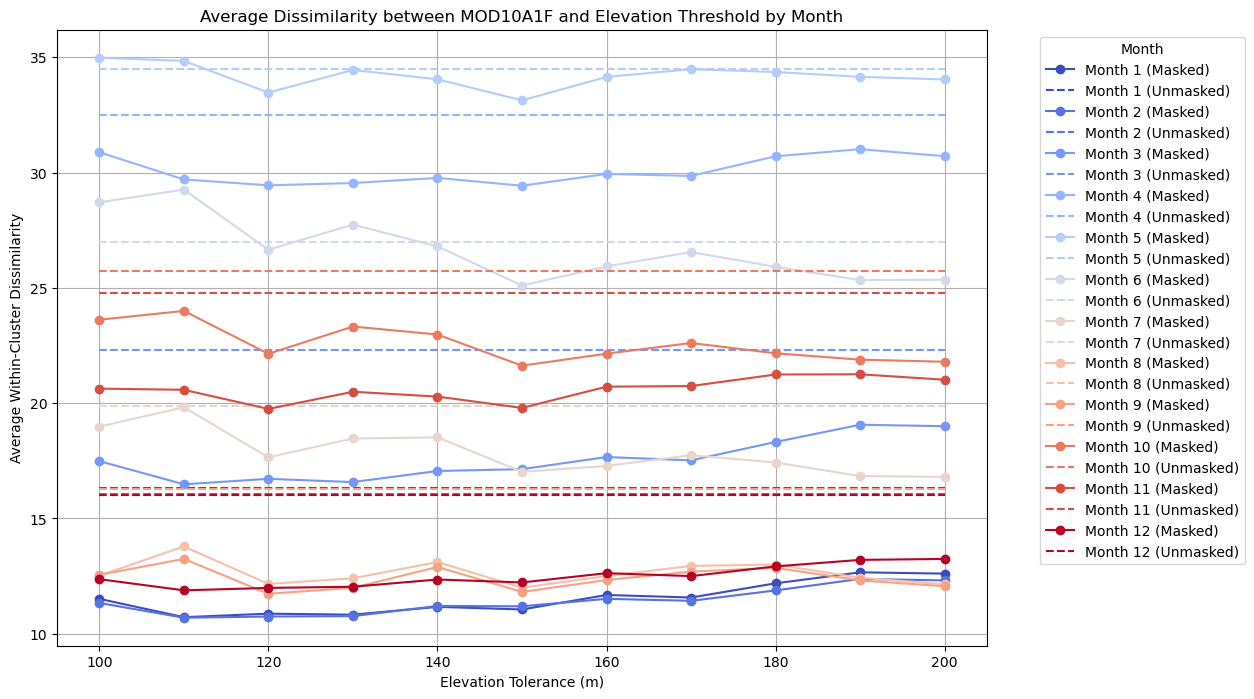

In [7]:
from scripts.imports import *
from rasterio.enums import Resampling
from rasterio.warp import reproject, calculate_default_transform
from rasterio.plot import show
from rasterio.windows import from_bounds
from scipy.spatial.distance import pdist
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
import pandas as pd
import os

# Additional helper functions as per your previous script context
def extract_nums(text, point='ul'):
    import re
    pattern = r'UpperLeftPointMtrs=\((.*?)\)' if point == 'ul' else r'LowerRightMtrs=\((.*?)\)'
    match = re.search(pattern, text)
    return tuple(map(float, match.group(1).split(','))) if match else (None, None)

# Set the specific location and extent to match the first plot
center_lat = 45.8238
center_lon = 7.5609
radius = 5000  # Half the size of the box for 10 km by 10 km

# Convert radius in meters to degrees approximately (rough approximation)
radius_deg_lat = radius / 111000
radius_deg_lon = radius / (111000 * np.cos(np.radians(center_lat)))

# Latitude and longitude bounds matching the first plot
lat_min = center_lat - radius_deg_lat
lat_max = center_lat + radius_deg_lat
lon_min = center_lon - radius_deg_lon
lon_max = center_lon + radius_deg_lon

# Function to get day of year (DOY) from a date in 'yyyy-mm-dd' format
def get_day_of_year(date_str):
    date_obj = pd.to_datetime(date_str)
    return date_obj.strftime('%j')

def find_matching_hdf(year, day_of_year, start, hdf_dirf):
    # Construct the prefix and suffix to match
    prefix = f'{start}10A1F.A{year}{day_of_year}'
    suffix = '.hdf'
    
    # List all files in the directory
    files = os.listdir(hdf_dir)
    
    # Find the matching HDF file
    for file in files:
        if file.startswith(prefix) and file.endswith(suffix):
            return file
    
    return None

# Function to convert HDF file to latitude and longitude arrays
def hdf_to_latlon(hdf_path):
    hdf = SD(hdf_path, SDC.READ)
    dataset = hdf.select('CGF_NDSI_Snow_Cover')
    data = dataset[:]
    ulx, uly = extract_nums(hdf.attributes()['StructMetadata.0'], point='ul')
    lrx, lry = extract_nums(hdf.attributes()['StructMetadata.0'], point='lr')
    nx, ny = data.shape
    xres = (lrx - ulx) / float(nx)
    yres = (uly - lry) / float(ny)
    x = np.linspace(ulx + xres / 2, lrx - xres / 2, nx)
    y = np.linspace(uly - yres / 2, lry + yres / 2, ny)
    xv, yv = np.meshgrid(x, y)
    proj = pyproj.Proj(proj='sinu', R=6371007.181, no_defs=True)
    lon, lat = proj(xv, yv, inverse=True)
    hdf.end()
    return lat, lon, data

# Dates to consider (you may adjust the date range)
start_date = '2018-11-01'
end_date = '2023-11-30'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Load the elevation data
tif_path = '../data_store/data/torgnon/elevation/w50535_s10.tif'
with rasterio.open(tif_path) as src:
    # Define the center point and box dimensions
    wgs84 = CRS.from_epsg(4326)
    tif_crs = src.crs
    transformer = Transformer.from_crs(wgs84, tif_crs, always_xy=True)
    center_x, center_y = transformer.transform(center_lon, center_lat)

    min_x = center_x - radius
    max_x = center_x + radius
    min_y = center_y - radius
    max_y = center_y + radius

    window = from_bounds(min_x, min_y, max_x, max_y, src.transform)
    elevation_data = src.read(1, window=window)

# Prepare to store results by month
tolerances = np.arange(100, 201, 10)
unmasked_tolerance = 10000  # Arbitrary large value for unmasked scenario

monthly_dissimilarity_results = {month: np.zeros(len(tolerances)) for month in range(1, 13)}
monthly_unmasked_dissimilarity = {month: 0 for month in range(1, 13)}
valid_days_count = {month: np.zeros(len(tolerances)) for month in range(1, 13)}

# Loop over all dates and compute the dissimilarity
for current_date in date_range:
    date_str = current_date.strftime('%Y-%m-%d')
    month = current_date.month
    day_of_year = get_day_of_year(date_str)
    year = date_str[:4]
    start = 'MOD'
    place = 'torgnon'
    hdf_dir = f'../data_store/data/{start}10A1F_{place}/'
    hdf_filename = find_matching_hdf(year, day_of_year, start, hdf_dir)

    if hdf_filename:
        hdf_path = os.path.join(hdf_dir, hdf_filename)
        latitude, longitude, snow_cover_data = hdf_to_latlon(hdf_path)

        # Find indices that match the region of interest
        lat_indices = np.where((latitude[:,0] >= lat_min) & (latitude[:,0] <= lat_max))[0]
        lon_indices = np.where((longitude[0,:] >= lon_min) & (longitude[0,:] <= lon_max))[0]

        # Crop the snow cover data based on the indices
        cropped_snow_cover_data = snow_cover_data[lat_indices.min():lat_indices.max()+1, lon_indices.min():lon_indices.max()+1]
        cropped_latitude = latitude[lat_indices.min():lat_indices.max()+1, lon_indices.min():lon_indices.max()+1]
        cropped_longitude = longitude[lat_indices.min():lat_indices.max()+1, lon_indices.min():lon_indices.max()+1]

        # Resample the elevation data to match the snow cover data resolution
        transform, width, height = calculate_default_transform(
            src.crs, wgs84, cropped_snow_cover_data.shape[1], cropped_snow_cover_data.shape[0],
            *src.bounds)
        elevation_data_resampled = np.empty_like(cropped_snow_cover_data, dtype=np.float32)

        reproject(
            source=elevation_data,
            destination=elevation_data_resampled,
            src_transform=src.window_transform(window),
            src_crs=src.crs,
            dst_transform=rasterio.transform.from_bounds(lon_min, lat_min, lon_max, lat_max, cropped_snow_cover_data.shape[1], cropped_snow_cover_data.shape[0]),
            dst_crs=wgs84,
            resampling=Resampling.bilinear
        )

        # Define the elevation of the location of interest
        location_elevation = 2091

        # For each snow cover pixel, evaluate the percentage of elevations within the tolerance
        pixel_size_y = elevation_data.shape[0] // cropped_snow_cover_data.shape[0]
        pixel_size_x = elevation_data.shape[1] // cropped_snow_cover_data.shape[1]

        for i, tolerance in enumerate(tolerances):
            mask = np.zeros_like(cropped_snow_cover_data, dtype=bool)

            for y in range(cropped_snow_cover_data.shape[0]):
                for x in range(cropped_snow_cover_data.shape[1]):
                    elevation_block = elevation_data[y*pixel_size_y:(y+1)*pixel_size_y, x*pixel_size_x:(x+1)*pixel_size_x]
                    elevation_values = elevation_block.flatten()
                    elevation_values = elevation_values[~np.isnan(elevation_values)]
                    within_tolerance = (elevation_values >= (location_elevation - tolerance)) & (elevation_values <= (location_elevation + tolerance))
                    percentage_within_tolerance = np.sum(within_tolerance) / len(elevation_values)
                    mask[y, x] = percentage_within_tolerance >= 0.80

            masked_snow_cover_data = np.where(mask, cropped_snow_cover_data, np.nan)
            valid_pixels = masked_snow_cover_data[~np.isnan(masked_snow_cover_data)]

            # Compute within-cluster dissimilarity
            if len(valid_pixels) > 1:  # Ensure there are at least two points to compare
                pairwise_distances = pdist(valid_pixels[:, None])  # Pairwise distances
                mean_dissimilarity = np.mean(pairwise_distances)  # Mean of pairwise distances
                monthly_dissimilarity_results[month][i] += mean_dissimilarity
                valid_days_count[month][i] += 1

        # Compute dissimilarity for the unmasked scenario
        mask = (elevation_data_resampled >= (location_elevation - unmasked_tolerance)) & (elevation_data_resampled <= (location_elevation + unmasked_tolerance))
        unmasked_snow_cover_data = np.where(mask, cropped_snow_cover_data, np.nan)
        unmasked_pixels = unmasked_snow_cover_data[~np.isnan(unmasked_snow_cover_data)]
        if len(unmasked_pixels) > 1:
            pairwise_distances_unmasked = pdist(unmasked_pixels[:, None])
            mean_dissimilarity_unmasked = np.mean(pairwise_distances_unmasked)
            monthly_unmasked_dissimilarity[month] += mean_dissimilarity_unmasked

# Average the dissimilarity results over all valid days for each month
for month in range(1, 13):
    monthly_dissimilarity_results[month] /= valid_days_count[month]
    monthly_unmasked_dissimilarity[month] /= np.max(valid_days_count[month])

# Plot all the results on a single plot
plt.figure(figsize=(12, 8))
colors = plt.cm.coolwarm(np.linspace(0, 1, 12))  # 12 distinct colors from the coolwarm colormap

for month in range(1, 13):
    plt.plot(tolerances, monthly_dissimilarity_results[month], marker='o', color=colors[month-1], label=f'Month {month} (Masked)')
    plt.plot([tolerances.min(), tolerances.max()], [monthly_unmasked_dissimilarity[month]]*2, color=colors[month-1], linestyle='--', label=f'Month {month} (Unmasked)')

plt.xlabel('Elevation Tolerance (m)')
plt.ylabel('Average Within-Cluster Dissimilarity')
plt.title('Average Dissimilarity between MOD10A1F and Elevation Threshold by Month')
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()
